In [11]:
import yfinance as yf

# 下载 QQQ 从 1999-03-19 到今天的日线数据
qqq = yf.download("QQQ", start="2009-03-19", end="2025-08-20", interval="1d", progress=False)

qqq.to_csv("QQQ_1999_2025.csv")

print("下载完成，已保存为 QQQ_1999_2025.csv")
print(qqq.head())
print(qqq.tail())

C:\Users\Yi\AppData\Local\Temp\ipykernel_14976\2612066635.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  qqq = yf.download("QQQ", start="2009-03-19", end="2025-08-20", interval="1d", progress=False)


下载完成，已保存为 QQQ_1999_2025.csv
Price           Close       High        Low       Open     Volume
Ticker            QQQ        QQQ        QQQ        QQQ        QQQ
Date                                                             
2009-03-19  25.714525  26.104401  25.523918  26.087074  146753400
2009-03-20  25.323147  26.060799  25.149581  25.765738  149410800
2009-03-23  26.815800  26.850514  25.340498  25.947974  179499000
2009-03-24  26.321140  26.798444  26.303783  26.590166  118757600
2009-03-25  26.442636  26.945975  25.739698  26.546776  190555200
Price            Close        High         Low        Open    Volume
Ticker             QQQ         QQQ         QQQ         QQQ       QQQ
Date                                                                
2025-08-13  580.340027  583.320007  578.940002  582.760010  41209300
2025-08-14  579.890015  581.880005  577.909973  578.280029  45425000
2025-08-15  577.340027  579.840027  575.570007  579.799988  49480200
2025-08-18  577.109985  577.77

In [12]:
import pandas as pd
import numpy as np

# 读取（跳过前两行头信息）
qqq_raw = pd.read_csv("QQQ_1999_2025.csv", skiprows=2)

# 统一列名
qqq_raw.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

# 基础清洗
qqq = qqq_raw.copy()
qqq["Date"] = pd.to_datetime(qqq["Date"])
qqq.set_index("Date", inplace=True)

for col in ["Close", "High", "Low", "Open", "Volume"]:
    qqq[col] = pd.to_numeric(qqq[col], errors="coerce")

# -------- 1) 参考价格：EMA30 --------
qqq["EMA30"] = qqq["Close"].ewm(span=30, adjust=False).mean()

# （可选）布林带参考：以 EMA30 为中轨 + rolling std 做带宽
# 这里 rolling std 用 Close 的滚动σ，也可以改成 (Close-EMA30) 的滚动σ
win_std = 30
qqq["roll_std30_close"] = qqq["Close"].rolling(win_std, min_periods=win_std//2).std()
qqq["BB_mid"] = qqq["EMA30"]
qqq["BB_up"]  = qqq["BB_mid"] + 2.0 * qqq["roll_std30_close"]
qqq["BB_dn"]  = qqq["BB_mid"] - 2.0 * qqq["roll_std30_close"]

# -------- 2) 因子 A：原始比值 (当天能与老板值对齐的那个) --------
qqq["Factor_A_ratio"] = (qqq["Close"] - qqq["EMA30"]) / qqq["Close"]

# 用整体均值/方差画水平线（仅用于可视化参考）
mean_A = qqq["Factor_A_ratio"].mean()
std_A  = qqq["Factor_A_ratio"].std()
levels_A = {
    "mean": mean_A,
    "+1σ": mean_A + std_A, "-1σ": mean_A - std_A,
    "+2σ": mean_A + 2*std_A, "-2σ": mean_A - 2*std_A
}

# -------- 3) 因子 B：波动归一化 Z-score（核心改动） --------
# 用滚动窗口（建议 ~250 交易日）对价差 (Close - EMA30) 做标准化
win_norm = 250
spread = qqq["Close"] - qqq["EMA30"]
roll_std_spread = spread.rolling(win_norm, min_periods=win_norm//3).std()

# 避免除零
eps = 1e-12
qqq["Factor_B_z"] = spread / (roll_std_spread.replace(0, np.nan) + eps)

# 因为 B 已经做了“局部σ标准化”，其分布大体以 0 为中心、单位量纲。
# 但为画水平线，仍取全样本的均值/σ（接近0/1，但不一定严格等于）。
mean_B = qqq["Factor_B_z"].mean(skipna=True)
std_B  = qqq["Factor_B_z"].std(skipna=True)
levels_B = {
    "mean": mean_B,
    "+1σ": mean_B + std_B, "-1σ": mean_B - std_B,
    "+2σ": mean_B + 2*std_B, "-2σ": mean_B - 2*std_B
}

# -------- 4) 输出检查 --------
print(qqq[["Close","EMA30","Factor_A_ratio","Factor_B_z"]].dropna().head())
print("\nLevels A:", levels_A)
print("Levels B:", levels_B)


                Close      EMA30  Factor_A_ratio  Factor_B_z
Date                                                        
2009-07-16  32.461811  30.977344        0.045730    2.002749
2009-07-17  32.635616  31.084329        0.047534    2.096461
2009-07-20  32.948406  31.204592        0.052926    2.353787
2009-07-21  33.174332  31.331672        0.055545    2.480236
2009-07-22  33.452362  31.468491        0.059304    2.656060

Levels A: {'mean': 0.00982742565041577, '+1σ': 0.03967945730137412, '-1σ': -0.02002460600054258, '+2σ': 0.06953148895233247, '-2σ': -0.04987663765150093}
Levels B: {'mean': 0.5079302188695849, '+1σ': 1.7114954183662539, '-1σ': -0.6956349806270841, '+2σ': 2.915060617862923, '-2σ': -1.899200180123753}


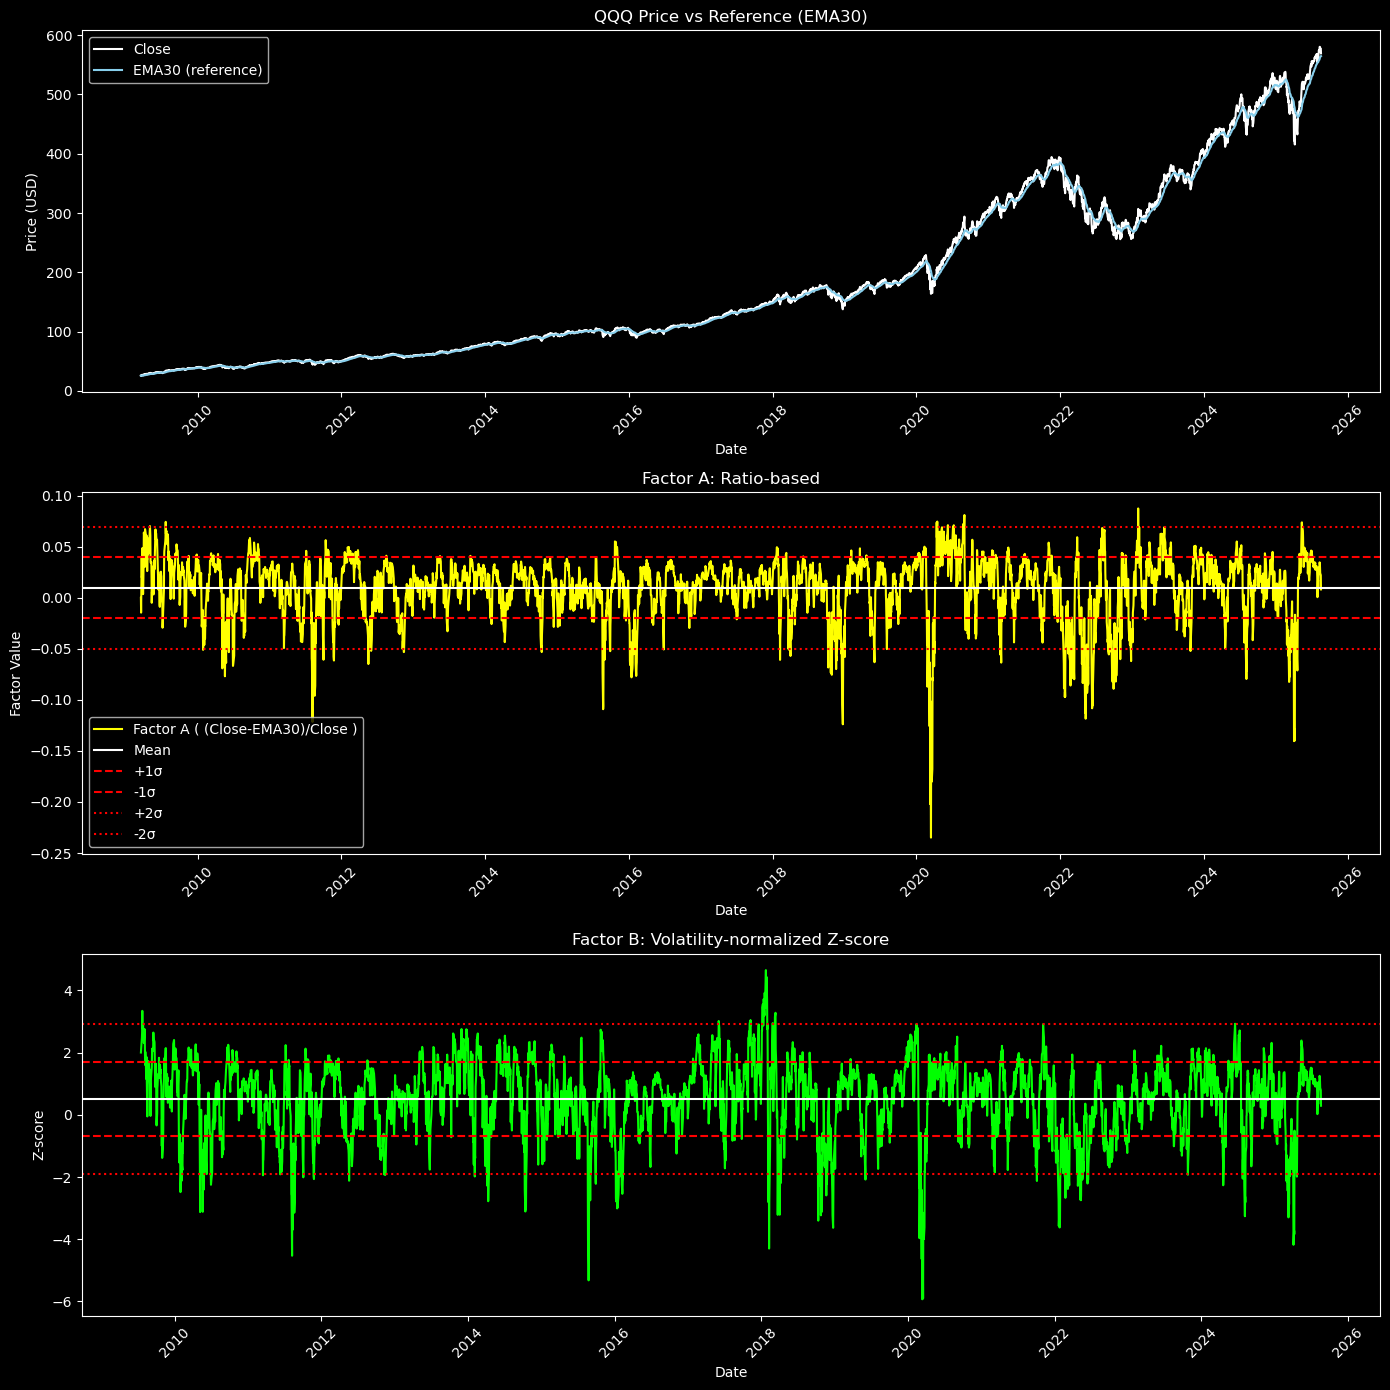

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,14))
plt.style.use("dark_background")

# -------- 上图: QQQ收盘价 + EMA30 --------
plt.subplot(3,1,1)
plt.plot(qqq.index, qqq["Close"], label="Close", color="white")
plt.plot(qqq.index, qqq["EMA30"], label="EMA30 (reference)", color="skyblue")
plt.title("QQQ Price vs Reference (EMA30)", color="white")
plt.xlabel("Date", color="white")
plt.ylabel("Price (USD)", color="white")
plt.xticks(rotation=45, color="white")
plt.yticks(color="white")
plt.legend()

# -------- 中图: 因子 A (原始比值) --------
plt.subplot(3,1,2)
plt.plot(qqq.index, qqq["Factor_A_ratio"], color="yellow", label="Factor A ( (Close-EMA30)/Close )")
plt.axhline(levels_A["mean"], color="white", linestyle="-", label="Mean")
plt.axhline(levels_A["+1σ"], color="red", linestyle="--", label="+1σ")
plt.axhline(levels_A["-1σ"], color="red", linestyle="--", label="-1σ")
plt.axhline(levels_A["+2σ"], color="red", linestyle=":", label="+2σ")
plt.axhline(levels_A["-2σ"], color="red", linestyle=":", label="-2σ")
plt.title("Factor A: Ratio-based", color="white")
plt.xlabel("Date", color="white")
plt.ylabel("Factor Value", color="white")
plt.xticks(rotation=45, color="white")
plt.yticks(color="white")
plt.legend()

# -------- 下图: 因子 B (波动归一化) --------
plt.subplot(3,1,3)
plt.plot(qqq.index, qqq["Factor_B_z"], color="lime", label="Factor B (Volatility-normalized Z)")
plt.axhline(levels_B["mean"], color="white", linestyle="-", label="Mean")
plt.axhline(levels_B["+1σ"], color="red", linestyle="--", label="+1σ")
plt.axhline(levels_B["-1σ"], color="red", linestyle="--", label="-1σ")
plt.axhline(levels_B["+2σ"], color="red", linestyle=":", label="+2σ")
plt.axhline(levels_B["-2σ"], color="red", linestyle=":", label="-2σ")
plt.title("Factor B: Volatility-normalized Z-score", color="white")
plt.xlabel("Date", color="white")
plt.ylabel("Z-score", color="white")
plt.xticks(rotation=45, color="white")
plt.yticks(color="white")
#plt.legend()

plt.tight_layout()
plt.show()


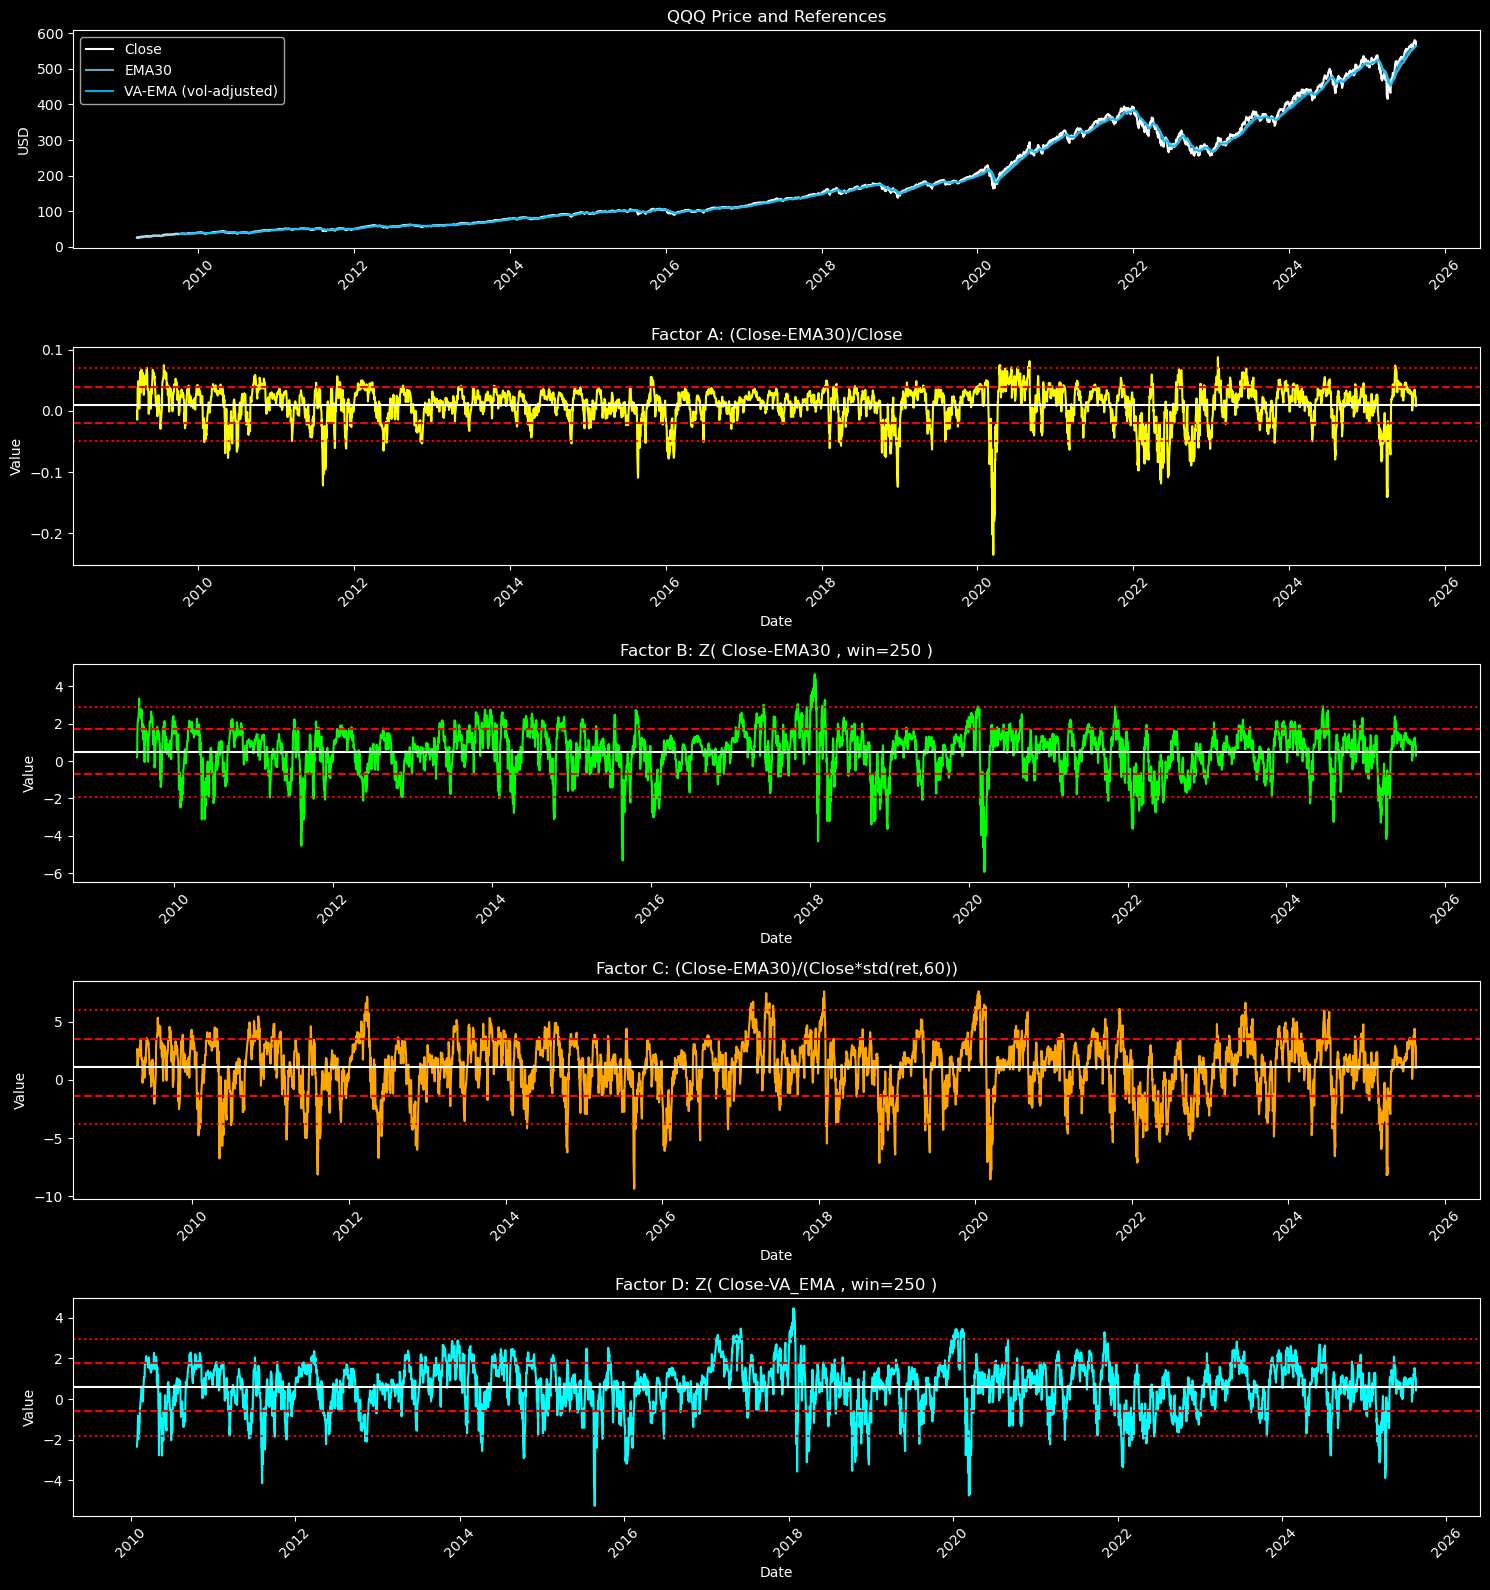

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reload file after kernel reset
df_raw = pd.read_csv("QQQ_1999_2025.csv", skiprows=2)
df_raw.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
qqq = df_raw.copy()
qqq["Date"] = pd.to_datetime(qqq["Date"])
qqq.set_index("Date", inplace=True)
for col in ["Close", "High", "Low", "Open", "Volume"]:
    qqq[col] = pd.to_numeric(qqq[col], errors="coerce")

# Base reference
qqq["EMA30"] = qqq["Close"].ewm(span=30, adjust=False).mean()
qqq["F_base"] = (qqq["Close"] - qqq["EMA30"]) / qqq["Close"]

# Z-score of spread (250d)
spread = qqq["Close"] - qqq["EMA30"]
qqq["spread_rolling_std_250"] = spread.rolling(250, min_periods=80).std()
qqq["F_z_spread250"] = spread / (qqq["spread_rolling_std_250"].replace(0, np.nan) + 1e-12)

# Volatility-normalized by returns std (60d)
ret = qqq["Close"].pct_change()
qqq["ret_std_60"] = ret.rolling(60, min_periods=20).std()
qqq["F_volnorm60"] = (qqq["Close"] - qqq["EMA30"]) / (qqq["Close"] * (qqq["ret_std_60"].replace(0, np.nan) + 1e-12))

# Volatility-adjusted EMA reference
base_span = 30.0
vol = qqq["ret_std_60"].copy()
vol_med = vol.rolling(500, min_periods=120).median()
vol_rel = (vol / vol_med).clip(lower=0.5, upper=2.0)
eff_span = (base_span / vol_rel).clip(lower=10, upper=90)
ref_va = []
ref_prev = None
for p, s in zip(qqq["Close"].values, eff_span.values):
    if np.isnan(p) or np.isnan(s):
        ref_va.append(np.nan)
        continue
    alpha = 2.0 / (s + 1.0)
    if ref_prev is None or np.isnan(ref_prev):
        ref = p
    else:
        ref = alpha * p + (1 - alpha) * ref_prev
    ref_va.append(ref)
    ref_prev = ref
qqq["Ref_VA_EMA"] = ref_va
spread_va = qqq["Close"] - qqq["Ref_VA_EMA"]
qqq["spread_va_std_250"] = spread_va.rolling(250, min_periods=80).std()
qqq["F_vaema_z250"] = spread_va / (qqq["spread_va_std_250"].replace(0, np.nan) + 1e-12)

# Levels helper
def levels(series):
    m = series.mean(skipna=True)
    s = series.std(skipna=True)
    return {"mean": m, "+1σ": m+s, "-1σ": m-s, "+2σ": m+2*s, "-2σ": m-2*s}

levels_base  = levels(qqq["F_base"])
levels_zsp   = levels(qqq["F_z_spread250"])
levels_vol   = levels(qqq["F_volnorm60"])
levels_vaz   = levels(qqq["F_vaema_z250"])

# Plot
plt.figure(figsize=(15,16))
plt.style.use("dark_background")

# Price + references
plt.subplot(5,1,1)
plt.plot(qqq.index, qqq["Close"], color="white", label="Close")
plt.plot(qqq.index, qqq["EMA30"], color="skyblue", alpha=0.8, label="EMA30")
plt.plot(qqq.index, qqq["Ref_VA_EMA"], color="deepskyblue", alpha=0.9, label="VA-EMA (vol-adjusted)")
plt.title("QQQ Price and References", color="white")
plt.ylabel("USD", color="white")
plt.xticks(rotation=45, color="white")
plt.yticks(color="white")
plt.legend()

# Panels function
def draw_panel(pos, series, lvls, title, color_line):
    plt.subplot(5,1,pos)
    plt.plot(qqq.index, series, color=color_line, label=title)
    plt.axhline(lvls["mean"], color="white", linestyle="-", label="Mean")
    plt.axhline(lvls["+1σ"], color="red", linestyle="--", label="+1σ")
    plt.axhline(lvls["-1σ"], color="red", linestyle="--", label="-1σ")
    plt.axhline(lvls["+2σ"], color="red", linestyle=":", label="+2σ")
    plt.axhline(lvls["-2σ"], color="red", linestyle=":", label="-2σ")
    plt.title(title, color="white")
    plt.xlabel("Date", color="white")
    plt.ylabel("Value", color="white")
    plt.xticks(rotation=45, color="white")
    plt.yticks(color="white")
    #plt.legend()

draw_panel(2, qqq["F_base"], levels_base, "Factor A: (Close-EMA30)/Close", "yellow")
draw_panel(3, qqq["F_z_spread250"], levels_zsp, "Factor B: Z( Close-EMA30 , win=250 )", "lime")
draw_panel(4, qqq["F_volnorm60"], levels_vol, "Factor C: (Close-EMA30)/(Close*std(ret,60))", "orange")
draw_panel(5, qqq["F_vaema_z250"], levels_vaz, "Factor D: Z( Close-VA_EMA , win=250 )", "cyan")

plt.tight_layout()
plt.show()


C:\Users\Yi\AppData\Local\Temp\ipykernel_14976\639638503.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  R_t = R_t.fillna(method="bfill")


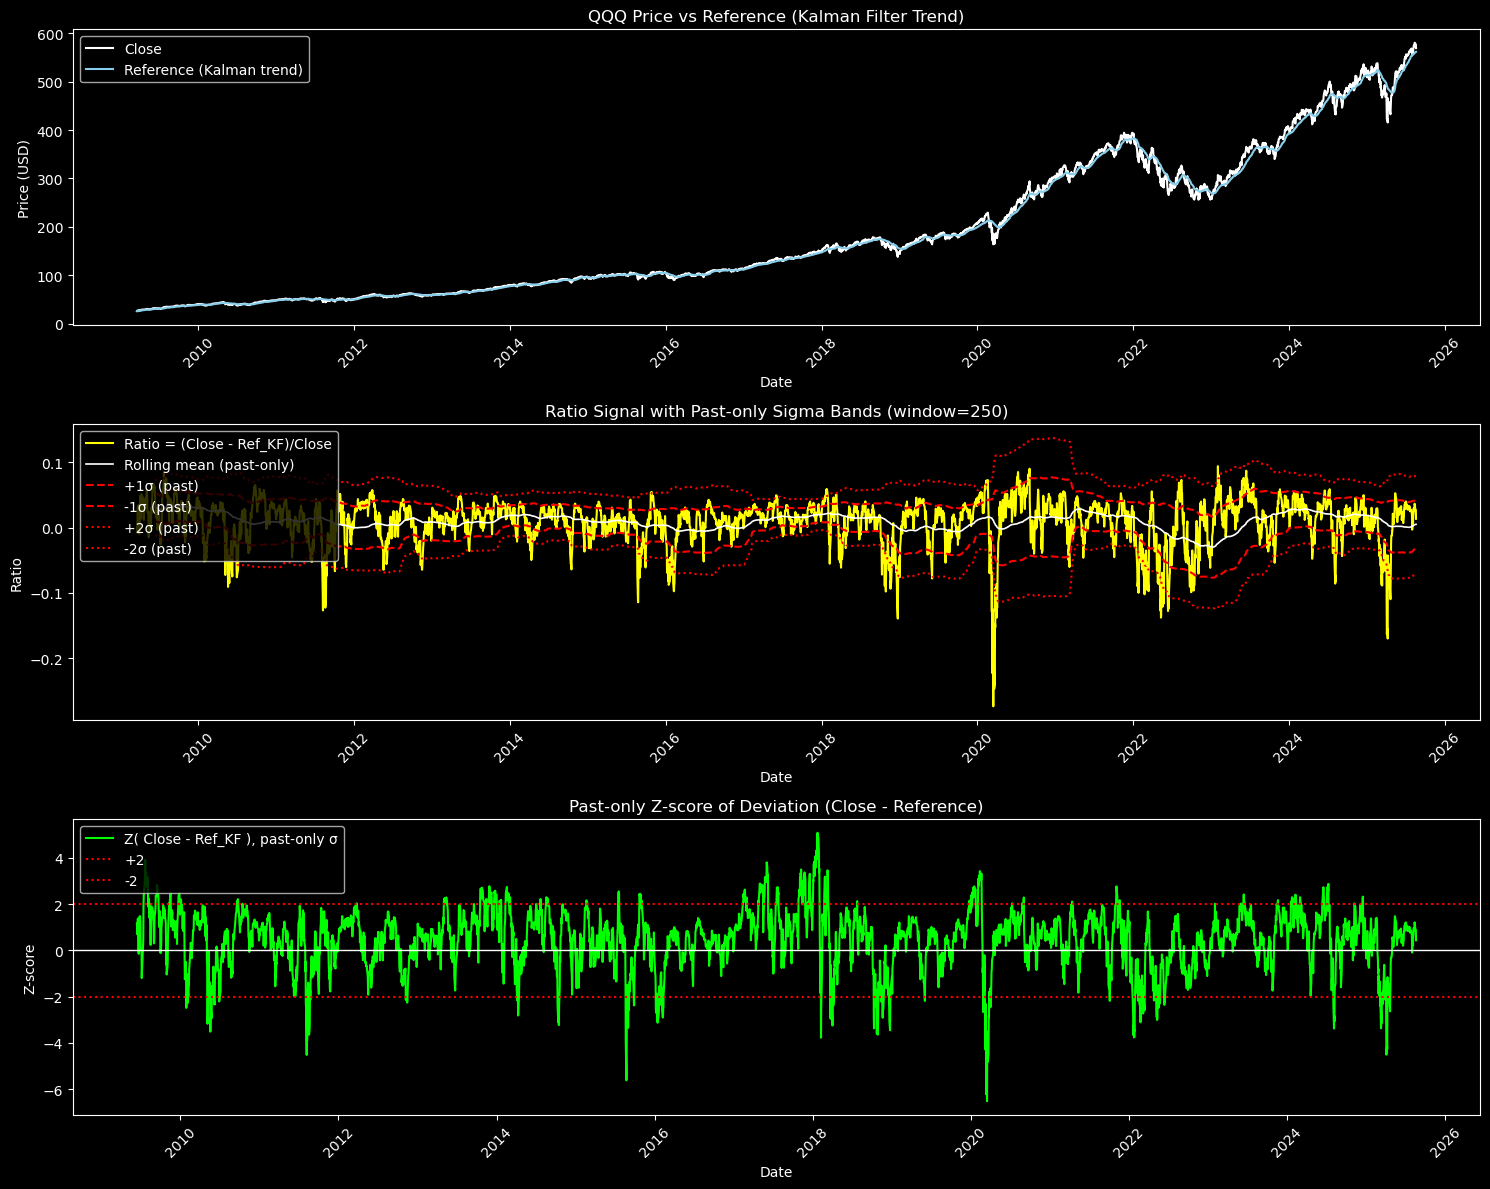

{'last_date': '2025-08-19',
 'Close': 569.280029296875,
 'Ref_KF': 561.6092931572628,
 'Ratio': 0.01347445149109915,
 'Z_spread_past': 0.43567822668570977}

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load data
df_raw = pd.read_csv("QQQ_1999_2025.csv", skiprows=2)
df_raw.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
qqq = df_raw.copy()
qqq["Date"] = pd.to_datetime(qqq["Date"])
qqq.set_index("Date", inplace=True)
for col in ["Close", "High", "Low", "Open", "Volume"]:
    qqq[col] = pd.to_numeric(qqq[col], errors="coerce")

# 2) New reference via Kalman Filter (local level), with past-only vol inputs
ret = qqq["Close"].pct_change()
ret_std20_past = ret.rolling(20, min_periods=5).std().shift(1)  # past-only
R_t = (qqq["Close"].shift(1) * ret_std20_past)**2
R_t = R_t.fillna(method="bfill")

q_factor = 0.05
Q_t = (q_factor**2) * R_t

ref_kf = []
x_prev = np.nan
P_prev = np.nan
for z_obs, q_var, r_var in zip(qqq["Close"].values, Q_t.values, R_t.values):
    if np.isnan(z_obs) or np.isnan(q_var) or np.isnan(r_var):
        ref_kf.append(np.nan)
        continue
    if np.isnan(x_prev):
        x_prev = z_obs
        P_prev = r_var if not np.isnan(r_var) else 1.0
        ref_kf.append(x_prev)
        continue
    x_pred = x_prev
    P_pred = P_prev + q_var
    K = P_pred / (P_pred + r_var) if (P_pred + r_var) > 0 else 0.0
    x_new = x_pred + K * (z_obs - x_pred)
    P_new = (1 - K) * P_pred
    ref_kf.append(x_new)
    x_prev, P_prev = x_new, P_new

qqq["Ref_KF"] = ref_kf

# 3) Ratio and past-only sigma bands
qqq["Ratio"] = (qqq["Close"] - qqq["Ref_KF"]) / qqq["Close"]

win_sigma = 250
ratio_std_past = qqq["Ratio"].rolling(win_sigma, min_periods=60).std().shift(1)
ratio_mean_past = qqq["Ratio"].rolling(win_sigma, min_periods=60).mean().shift(1)

qqq["Ratio_mean_past"] = ratio_mean_past
qqq["+1sigma"] = ratio_mean_past + ratio_std_past
qqq["-1sigma"] = ratio_mean_past - ratio_std_past
qqq["+2sigma"] = ratio_mean_past + 2*ratio_std_past
qqq["-2sigma"] = ratio_mean_past - 2*ratio_std_past

# 4) Optional: past-only Z of spread
spread = qqq["Close"] - qqq["Ref_KF"]
spread_std_past = spread.rolling(win_sigma, min_periods=60).std().shift(1)
qqq["Z_spread_past"] = spread / spread_std_past

# 5) Plots
plt.figure(figsize=(15,12))
plt.style.use("dark_background")

# Price & reference
plt.subplot(3,1,1)
plt.plot(qqq.index, qqq["Close"], color="white", label="Close")
plt.plot(qqq.index, qqq["Ref_KF"], color="skyblue", label="Reference (Kalman trend)")
plt.title("QQQ Price vs Reference (Kalman Filter Trend)")
plt.xlabel("Date"); plt.ylabel("Price (USD)")
plt.xticks(rotation=45); plt.legend()

# Ratio + past-only sigma
plt.subplot(3,1,2)
plt.plot(qqq.index, qqq["Ratio"], color="yellow", label="Ratio = (Close - Ref_KF)/Close")
plt.plot(qqq.index, qqq["Ratio_mean_past"], color="white", linewidth=1.2, label="Rolling mean (past-only)")
plt.plot(qqq.index, qqq["+1sigma"], color="red", linestyle="--", label="+1σ (past)")
plt.plot(qqq.index, qqq["-1sigma"], color="red", linestyle="--", label="-1σ (past)")
plt.plot(qqq.index, qqq["+2sigma"], color="red", linestyle=":", label="+2σ (past)")
plt.plot(qqq.index, qqq["-2sigma"], color="red", linestyle=":", label="-2σ (past)")
plt.title("Ratio Signal with Past-only Sigma Bands (window=250)")
plt.xlabel("Date"); plt.ylabel("Ratio")
plt.xticks(rotation=45); plt.legend(loc="upper left")

# Z-score panel
plt.subplot(3,1,3)
plt.plot(qqq.index, qqq["Z_spread_past"], color="lime", label="Z( Close - Ref_KF ), past-only σ")
plt.axhline(0, color="white", linewidth=1.0)
plt.axhline(2, color="red", linestyle=":", label="+2")
plt.axhline(-2, color="red", linestyle=":", label="-2")
plt.title("Past-only Z-score of Deviation (Close - Reference)")
plt.xlabel("Date"); plt.ylabel("Z-score")
plt.xticks(rotation=45); plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

# Output last values for quick inspection
last = qqq.dropna().index[-1]
{
    "last_date": str(last.date()),
    "Close": float(qqq.loc[last, "Close"]),
    "Ref_KF": float(qqq.loc[last, "Ref_KF"]),
    "Ratio": float(qqq.loc[last, "Ratio"]),
    "Z_spread_past": float(qqq.loc[last, "Z_spread_past"]),
}